<a href="https://colab.research.google.com/github/OlyKoek/Udemy-AIperfectMaster-colabo/blob/main/lstm_rnn_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなLSTMとRNNとTransformerの実装と比較

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, SimpleRNN, LSTM, Input, MultiHeadAttention, Add, LayerNormalization
from keras import optimizers

## 訓練用データの作成
RNNに用いる訓練用のデータを作成します。  
サイン関数に乱数でノイズを加えたデータを作成し、過去の時系列データから未来の値を予測できるようにします。

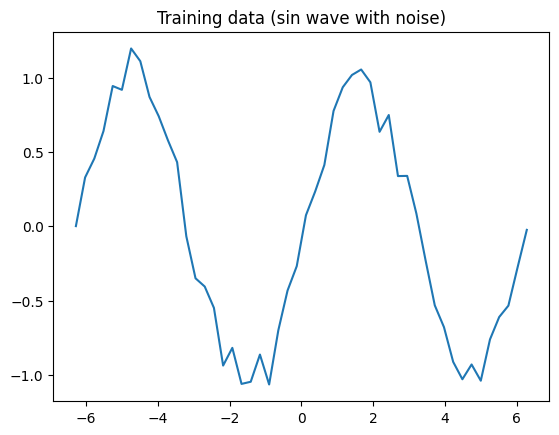

x: (40, 10, 1) t: (40, 10, 1)


In [24]:
x_data = np.linspace(-2*np.pi, 2*np.pi)
sin_data = np.sin(x_data) + 0.1 * np.random.randn(len(x_data))

plt.plot(x_data, sin_data)
plt.title("Training data (sin wave with noise)")
plt.show()

n_rnn = 10
n_sample = len(x_data) - n_rnn
x = np.zeros((n_sample, n_rnn))
t = np.zeros((n_sample, n_rnn))

for i in range(n_sample):
    x[i] = sin_data[i:i+n_rnn]
    t[i] = sin_data[i+1:i+n_rnn+1]

x = x.reshape(n_sample, n_rnn, 1)
t = t.reshape(n_sample, n_rnn, 1)
print("x:", x.shape, "t:", t.shape)


### テスト用の来予測関数を作成

In [25]:
def predict_future(model, x, n_rnn, steps=500):
    predicted = x[0].reshape(-1)
    for _ in range(len(x) + steps):
        y = model.predict(predicted[-n_rnn:].reshape(1, n_rnn, 1), verbose=0)
        predicted = np.append(predicted, y[0][-1][0])
    return predicted

## 勾配を追跡する関数を作成

In [26]:
class GradientTracker(tf.keras.callbacks.Callback):
    def __init__(self, model, x, y):
        self.model = model
        self.x = x
        self.y = y
        self.grad_norms = []

    def on_epoch_end(self, epoch, logs=None):
        with tf.GradientTape() as tape:
            preds = self.model(self.x, training=True)
            loss = tf.keras.losses.mean_squared_error(self.y, preds)
            loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, self.model.trainable_variables)
        total_norm = tf.linalg.global_norm(grads)
        self.grad_norms.append(total_norm.numpy())

## Simple RNN
Kerasを使ってRNNを構築します。  
Kerasが持つRNNの中で一番シンプルなSimpleRNN層を使います。

In [27]:
model_rnn = Sequential([
    SimpleRNN(20, input_shape=(n_rnn, 1), return_sequences=True),
    Dense(1)
])
print(model_rnn.summary())

model_rnn.compile(loss="mse", optimizer="adam")
history_rnn = model_rnn.fit(x, t, epochs=50, batch_size=8, verbose=0, validation_split=0.1)
pred_rnn = predict_future(model_rnn, x, n_rnn)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, 10, 20)         │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10, 1)          │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
model_rnn_no_clip = Sequential([
    SimpleRNN(20, input_shape=(n_rnn, 1), return_sequences=True),
    Dense(1)
])
print(model_rnn_no_clip.summary())

optimizer_no_clip = keras.optimizers.SGD(learning_rate=0.5)
model_rnn_no_clip.compile(loss="mse", optimizer=optimizer_no_clip)

history_no_clip = model_rnn_no_clip.fit(
    x, t,
    epochs=50,
    batch_size=8,
    verbose=0
)




model_rnn_clip = Sequential([
    SimpleRNN(20, input_shape=(n_rnn, 1), return_sequences=True),
    Dense(1)
])
print(model_rnn_clip.summary())

optimizer_clip = optimizers.SGD(learning_rate=0.5, clipnorm=1.0)  # ←これだけでOK！
model_rnn_clip.compile(loss="mse", optimizer=optimizer_clip)

history_clip = model_rnn_clip.fit(
    x, t,
    epochs=50,
    batch_size=8,
    verbose=0
)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_11 (SimpleRNN)       │ (None, 10, 20)         │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10, 1)          │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_12 (SimpleRNN)       │ (None, 10, 20)         │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10, 1)          │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

None


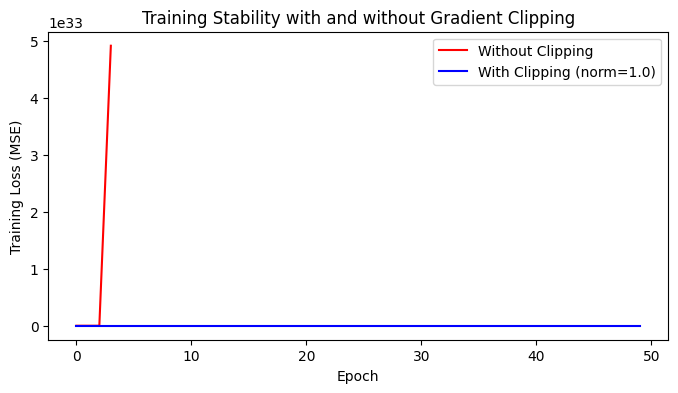

In [ ]:

# plt.figure(figsize=(8,4))
# plt.plot(history_no_clip.history["loss"], label="Without Clipping", color="red")
# plt.plot(history_clip.history["loss"], label="With Clipping (norm=1.0)", color="blue")
# plt.xlabel("Epoch")
# plt.ylabel("Training Loss (MSE)")
# plt.title("Training Stability with and without Gradient Clipping")
# plt.legend()
# plt.show()

# pred_no_clip = predict_future(model_rnn_no_clip, x, n_rnn)
# pred_clip = predict_future(model_rnn_clip, x, n_rnn)

# plt.figure(figsize=(12,6))
# plt.plot(np.arange(len(sin_data)), sin_data, label="True data", color="black", linewidth=1.5)
# plt.plot(np.arange(len(pred_no_clip)), pred_no_clip, label="No Clipping", color="red")
# plt.plot(np.arange(len(pred_clip)), pred_clip, label="With Clipping", color="blue")
# plt.axvline(len(sin_data), color="gray", linestyle="--", label="Prediction Start")
# plt.title("Effect of Gradient Clipping on Future Prediction (RNN)")
# plt.legend()
# plt.show()

### Simple LSTM

In [30]:
model_lstm = Sequential([
    LSTM(20, input_shape=(n_rnn, 1), return_sequences=True),
    Dense(1)
])
print(model_lstm.summary())

model_lstm.compile(loss="mse", optimizer="adam")
history_lstm = model_lstm.fit(x, t, epochs=50, batch_size=8, verbose=0, validation_split=0.1)
pred_lstm = predict_future(model_lstm, x, n_rnn)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10, 1)          │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

None


### Simple Transformer

In [31]:
inputs = Input(shape=(n_rnn, 1))
x_tf = Dense(32)(inputs)  # embedding 的役割
attn_out = MultiHeadAttention(num_heads=2, key_dim=8)(x_tf, x_tf)
x_tf = Add()([x_tf, attn_out])  # 残差接続
x_tf = LayerNormalization()(x_tf)
x_tf = Dense(20, activation="relu")(x_tf)
outputs = Dense(1)(x_tf)

model_tf = Model(inputs, outputs)
model_tf.compile(loss="mse", optimizer="adam")
print(model_tf.summary())

model_tf = Model(inputs, outputs)
model_tf.compile(loss="mse", optimizer="adam")
history_tf = model_tf.fit(x, t, epochs=50, batch_size=8, verbose=0, validation_split=0.1)
pred_tf = predict_future(model_tf, x, n_rnn)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 10, 32)    │         64 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 32)    │      2,128 │ dense_14[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 32)    │          0 │ dense_14[0][0],   │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 32)    │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 10, 20)    │        660 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 10, 1)     │         21 │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,937 (11.47 KB)

 Trainable params: 2,937 (11.47 KB)

 Non-trainable params: 0 (0.00 B)

None


## 損失関数の比較

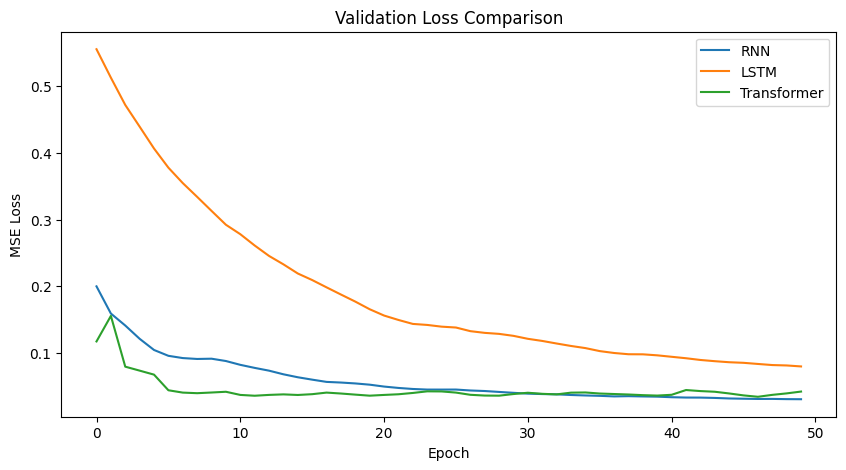

In [36]:
plt.figure(figsize=(10,5))
plt.plot(history_rnn.history["val_loss"], label="RNN")
# plt.plot(history_no_clip.history["loss"], label="Without Clipping", color="red")
# plt.plot(history_clip.history["loss"], label="With Clipping (norm=1.0)")
plt.plot(history_lstm.history["val_loss"], label="LSTM")
plt.plot(history_tf.history["val_loss"], label="Transformer")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

## 推論による予測波形の表示

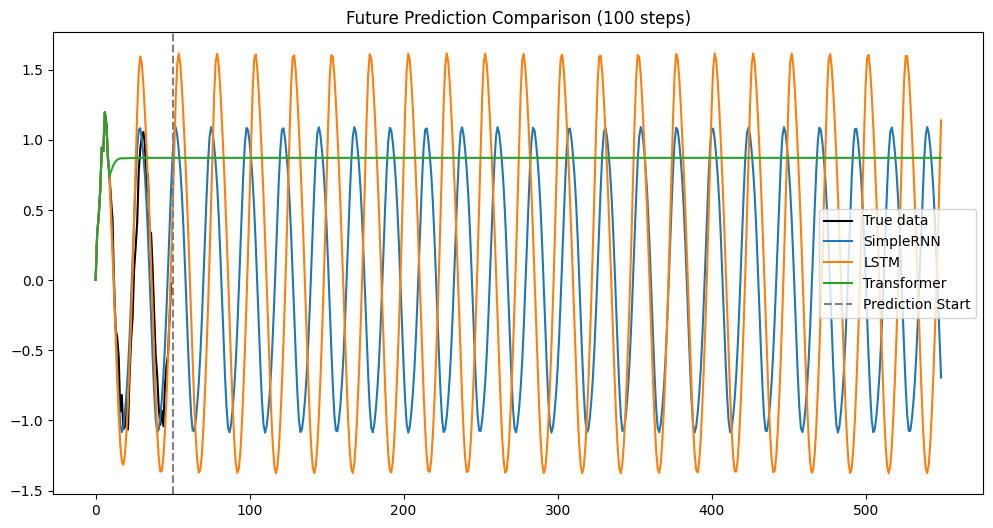

In [37]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(sin_data)), sin_data, label="True data", color="black", linewidth=1.5)
plt.plot(np.arange(len(pred_rnn)), pred_rnn, label="SimpleRNN")
plt.plot(np.arange(len(pred_lstm)), pred_lstm, label="LSTM")
plt.plot(np.arange(len(pred_tf)), pred_tf, label="Transformer")
plt.axvline(len(sin_data), color="gray", linestyle="--", label="Prediction Start")
plt.title("Future Prediction Comparison (100 steps)")
plt.legend()
plt.show()

"""
# 📘 モデル比較まとめ：SimpleRNN / LSTM / Transformer

##  SimpleRNN
### 概要
- 最も基本的な再帰型ニューラルネットワーク（Recurrent Neural Network）
- 現在の入力と「直前の出力状態」を再帰的に使って次を予測
- 時系列データを“逐次的”に処理する仕組み

### 特徴
- 短い依存関係（直近の傾向）を捉えるのは得意
- 長期依存（遠い過去の影響）を学習しづらい（勾配消失問題）
- モデル構造が単純で学習が速いが、波形が長期的にずれる傾向

### 本実験での挙動
- ノイズを含んだsin波の短周期はうまく追従
- ただし、周期が続くほど波形が徐々に平滑化・減衰するらしい
- 学習データが短い場合（1〜2周期）では安定だが長期予測に弱い

---

##  LSTM（Long Short-Term Memory）
### 概要
- RNNの勾配消失を防ぐために生まれた改良モデル
- 「セル状態」を内部に持ち、重要情報を保持・不要情報を忘却
- 入力・出力・忘却ゲートの3機構で情報を制御

### 特徴
- 長期依存の学習が可能（周期・トレンドの再現力が高い）
- 出力の滑らかさや周期再現性がRNNよりも安定
- ただし、データが少ないと振幅（上下のスケール）が過学習的に広がることがある

### 本実験での挙動
- 周期（波の長さ）はRNNより明確に再現
- ただし、振幅（縦方向のスケール）がやや大きくなる
- 少量データ＋Adam最適化による過適応傾向が見られる
- 対策としては正則化やデータ拡張、RMSPropなどの最適化が有効

---

##  Transformer
### 概要
- RNNやLSTMのような「再帰構造」を持たない新しいアーキテクチャ
- Attention機構により「過去の全入力」から関連度を動的に計算
- 位置情報（Positional Encoding）を与えることで時系列順序を理解

### 特徴
- 長期依存・複雑な時系列・非周期データの学習に非常に強い
- 並列計算が可能で学習効率が高い
- 少量データでは平均化傾向が強く、平坦な予測（直線）になりがち

### 本実験での挙動
- 損失関数（MSE）は最も小さい → 平均的に“安全な出力”を選択している
- しかし波形の追従性は低く、周期性を再現できない
- 原因は「位置情報の欠如」と「データ量不足」
- Positional Encodingを導入すると周期性が部分的に復活

---

## 総評（今回のsin波タスク）

| 観点 | SimpleRNN | LSTM | Transformer |
|------|------------|------|--------------|
| 波形の追従性 | ◯ | ◎ | △ |
| 長期予測の安定性 | △ | ◎ | ◯（位置情報次第） |
| 損失値（MSE） | 中 | 低 | 最低（ただし平坦化傾向） |
| 計算速度 | ◎（最速） | ◯ | △（Attention計算あり） |
| 少量データ適性 | ◎ | ◯ | × |
| 拡張余地 | 低 | 中 | 高（改良次第で最強） |

---

## まとめ
- **SimpleRNN**：時系列学習の原点。構造は単純で理解に最適。
- **LSTM**：実務レベルで最も安定。周期やトレンド再現に強い。
- **Transformer**：Attentionの威力で「過去全体」を見渡せるが、  
　位置情報と十分な学習データがなければ波形再現は困難。  
　時系列タスクではPositional Encodingの導入が必須。
